In [29]:
## popular python packages
import numpy as np
import matplotlib.pyplot as plt
from dask_quantumtinkerer import Cluster, cluster_options
import tinyarray as ta

# packages used here
import kwant

import sys, os

# pre-defined functions
sys.path.append(os.path.join(sys.path[0] + '/code/'))
from optimization import Optimize, hamiltonian, optimize_phase_fn, optimize_gate_fn
import parameters
from constants import scale, majorana_pair_indices
from utils import voltage_dict, eigsh, svd_transformation

sys.path.append(os.path.join(ROOT_DIR + '/spin-qubit/'))

In [3]:
options = cluster_options()
options.worker_cores = 2
options.worker_memory = 10
options.extra_path = "/home/srangaswamykup/trijunction_design/code/"
cluster_dashboard_link = "http://io.quantumtinkerer.tudelft.nl/user/srangaswamykup/proxy/"

# Y-shaped geometry

#### Parameters

In [4]:
import json
filename = 'config.json'
saveat = os.path.join(ROOT_DIR, 'code/')
with open(saveat + filename , 'r') as outfile:
    config = json.load(outfile)

In [5]:
dielectric_thickness = [0.5, 1, 1.5, 2.0]
gate_separation = [7, 9, 11, 13, 15]

In [8]:
optimize = Optimize(config, 
                    poisson_system = [],
                    linear_problem = [],
                    boundaries = [],
                    scale = scale
                   )

In [9]:
%%time
_, boundaries, poisson_system, linear_problem = optimize.changeconfig([])

Finding closed voronoi cells
Done selecting closed voronoi cells
Calculating points distance
Done
Calculating ridges hypersurfaces
Done
Finding  hypervolume for closed voronoi cells
Done finding hypervolume for closed voronoi cells
Done calculating surface
Done calculating distance
Done calculating capacitance matrix
Finding linear part of the tight-binding Hamiltonian


100%|██████████| 13/13 [00:09<00:00,  1.44it/s]


CPU times: user 1min 30s, sys: 4.41 s, total: 1min 34s
Wall time: 1min 34s


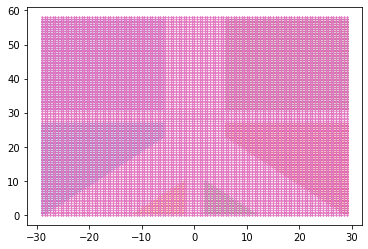

In [10]:
optimize.plot('GATES')

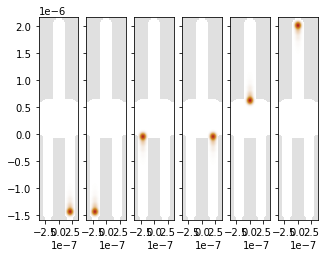

In [12]:
optimize.plot('WANNIER_FUNCTIONS')

In [13]:
optimize.set_voltages([-3.5e-3, -3.5e-3, -3.5e-3, -3.5e-3, -3.5e-3, -3.5e-3, 3e-3])

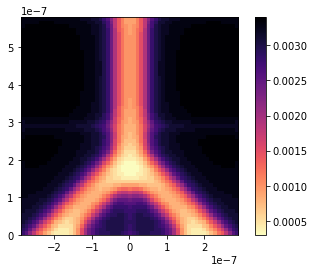

In [14]:
optimize.plot('POTENTIAL')

In [30]:
from collections import OrderedDict
pairs = ['right-top', 'left-top', 'left-right']
voltages = OrderedDict()
initial_condition = OrderedDict()
for i, pair in enumerate(pairs):
    initial = [-1.5e-3, -1.5e-3, -1.5e-3, 3e-3]
    initial[i] = -3.5e-3
    voltages[pair] = voltage_dict(initial, True)
    initial_condition[pair] = initial.copy()

In [31]:
poisson_params = {'poisson_system': poisson_system,
                  'linear_problem': linear_problem,
                  'site_coords': optimize.site_coords,
                  'site_indices': optimize.site_indices,
                  'offset': optimize.offset
                 }
params = parameters.junction_parameters(m_nw=parameters.bands[0] * np.ones(3))

kwant_params = {'kwant_sys': optimize.trijunction,
                'kwant_params_fn': optimize.f_params,
                'general_params': params,
                'linear_terms': optimize.optimizer_args['linear_terms']}

In [32]:
zero_potential = dict(zip(ta.array(optimize.site_coords[:, [0, 1]]), np.zeros(len(optimize.site_coords))))

kwant_params['general_params'].update(potential=zero_potential)

In [33]:
def wave_functions_coupling(pair, 
                      optimal_phase, 
                      voltages, 
                      kwant_system, 
                      kwant_params, 
                      kwant_params_fn, 
                      linear_terms, 
                      mlwf,
                      energy_scale):
   
    kwant_params.update(optimal_phase)
    
    if not isinstance(voltages, dict): 
        voltages = voltage_dict(voltages, True)

    params = {**kwant_params, **linear_terms}
    
    
    numerical_hamiltonian = hamiltonian(kwant_system, 
                                        voltages, 
                                        kwant_params_fn, 
                                        **params
                                       )
    
    energies, wave_functions = eigsh(
        numerical_hamiltonian.tocsc(),
        6,
        sigma=0,
        return_eigenvectors=True
    )
    
    pair_indices = majorana_pair_indices[pair].copy()
    pair_indices.append(list(set(range(3)) - set(pair_indices))[0])
    shuffle = pair_indices + [-3, -2, -1]
    desired_order = np.array(list(range(2, 5)) + list(range(2)) + [5])[shuffle]
    
    
    reference_wave_functions = mlwf[desired_order]
    
    transformed_hamiltonian = svd_transformation(
        energies,
        wave_functions,
        reference_wave_functions
    )/energy_scale
    
    coupled = np.abs(transformed_hamiltonian[0, 1])
    uncoupled = np.abs([transformed_hamiltonian[1, 2], transformed_hamiltonian[2, 3]])

    
    return wave_functions, coupled, uncoupled



In [34]:
%%time

intermediate_couplings = []

iteration = 0
tol = 1e-1
max_tol = 1e-2

voltages = [voltages[pair] for pair in [pairs[0], pairs[2]]]

del initial_condition['left-top']

while np.any(tol > max_tol):

    optimal_phases = optimize_phase_fn(voltages, 
                                       [pairs[0], pairs[2]], 
                                       kwant_params, 
                                       10)
    
    # A = datetime.datetime.now()
    optimal_voltages = optimization.optimize_gate_fn([pairs[0], pairs[2]], 
                                         initial_condition, 
                                         optimal_phases,
                                        optimize.optimizer_args,
                                        optimize.topological_gap
                                        )
    # B = datetime.datetime.now()
    # print(f'Optimization took {B - A}')
    
    voltages = [voltage_dict(optimal_voltages[pair].x, 
                             True) for pair in [pairs[0], 
                                                pairs[2]]]
    for pair in [pairs[0], pairs[2]]: 
        initial_condition[pair] = optimal_voltages[pair].x


    couplings = {}
    for voltage, pair in zip(voltages, [pairs[0], 
                                        pairs[2]]):
        _, coupling, _ = wave_functions_coupling(pair, 
                                                 optimal_phases[pair], 
                                                 voltage, 
                                                 optimize.trijunction, 
                                                 kwant_params['general_params'], 
                                                 optimize.f_params, 
                                                 optimize.optimizer_args['linear_terms'], 
                                                 optimize.mlwf,
                                                 optimize.topological_gap
                             )
        couplings[pair] = coupling
    
    intermediate_couplings.append(np.array(list(couplings.values())))

    if iteration > 1: tol = np.diff(intermediate_couplings[-2:], axis = 0)
    
    iteration += 1

Optimizing pair right-top
| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   5   |   0   | -3.0728e+00 | 1.00e-04 | 1.21e+03 | 0.00e+00 |
|   2   |  10   |   1   | -3.1800e+00 | 2.00e-04 | 7.74e+02 | 0.00e+00 |
|   3   |  15   |   2   | -3.2999e+00 | 1.40e-03 | 3.00e+02 | 0.00e+00 |
|   4   |  20   |   4   | -3.3882e+00 | 1.56e-03 | 3.66e+02 | 0.00e+00 |
|   5   |  25   |   7   | -3.3882e+00 | 7.79e-04 | 3.66e+02 | 0.00e+00 |
|   6   |  30   |   9   | -3.3882e+00 | 3.89e-04 | 3.66e+02 | 0.00e+00 |
|   7   |  35   |  11   | -3.3882e+00 | 1.95e-04 | 3.66e+02 | 0.00e+00 |
|   8   |  40   |  13   | -3.4594e+00 | 1.36e-03 | 4.87e+02 | 0.00e+00 |
|   9   |  45   |  17   | -3.4594e+00 | 1.36e-04 | 4.87e+02 | 0.00e+00 |
|  10   |  50   |  18   | -3.4594e+00 | 2.67e-05 | 4.87e+02 | 0.00e+00 |
|  11   |  55   |  19   | -3.4770e+00 | 1.87e-04 | 5.26e+02 | 0.00e+00 |
|  12   |  60   |  20   |

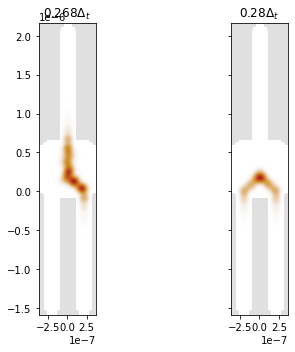

In [199]:
sfig, ax = plt.subplots(1, 2, figsize = (10, 5), sharey= True)

for i, pair in enumerate([pairs[0], pairs[2]]):
    wave_functions, coupling, _ = wave_functions_coupling(pair, 
                                                  optimal_phases[pair], 
                                                  optimal_voltages[pair].x, 
                                                  optimize.trijunction, 
                                                  kwant_params['general_params'], 
                                                  optimize.f_params, 
                                                  optimize.optimizer_args['linear_terms'], 
                                                  optimize.mlwf,
                                                  optimize.topological_gap
                     )


    kwant.plotter.density(optimize.trijunction, optimize.densityoperator(wave_functions[:, -1]), ax = ax[i]);
    ax[i].set_title(f'{np.round(coupling, 3)}'+r'$\Delta_t$');
    plt.tight_layout()

In [212]:
pair = pairs[2]
optimization_args = [optimize.site_coords, 
                     optimize.trijunction, optimize.f_params,
                     optimize.optimizer_args['linear_terms'], 
                     optimize.mlwf, optimal_phases[pair],
                    pair, optimize.topological_gap]

# Parallel simulation

In [ ]:
def optimize_thickness_gap(newconfig):
        
    
    return solver


In [ ]:
cluster_dashboard_link = "http://io.quantumtinkerer.tudelft.nl/user/srangaswamykup/proxy/"

with Cluster(options) as cluster:
    cluster.scale(n=len(sequence))
    client = cluster.get_client()
    print(cluster_dashboard_link + cluster.dashboard_link[17:])
    solver = optimize_thickness_gap()
    results = []
    futures = client.map(optimize_thickness_gap(), sequence)
    for future in futures:
        if future.status == 'error':
            print('Error!')
            results.append('E')
        else:
            results.append(future.result())

http://io.quantumtinkerer.tudelft.nl/user/srangaswamykup/proxy/8000/clusters/8533abbea10048429485c2c7d9afcd3c/status


In [201]:
def test_parallel(i):
    if i == 2: print(a)
    return i

In [205]:
with Cluster(options) as cluster:
    cluster.scale(n=5)
    client = cluster.get_client()
    print(cluster_dashboard_link + cluster.dashboard_link[17:])
    futures = client.map(test_parallel, range(5))
    for future in futures:
        if future.status == 'error':
            print('Error!')
        else:
            print(future.result())

http://io.quantumtinkerer.tudelft.nl/user/srangaswamykup/proxy/8000/clusters/7fe1bde7fbe64a7aac85c0fee78b119c/status
0
1
Error encountered!
3
4
